## Import Libraries
Predict the number of inquiries a new listing receives based on the listing’s creation date and other features.

Based on personal experience, we can tell an apartment which is cheaper and closer to main amenities will be quite popular. Let's verify "What the data says?"

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from collections import defaultdict, Counter
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import scikitplot.plotters as skplt
import folium
from lightgbm import LGBMClassifier
import lightgbm as lgb
import warnings
from pdpbox import pdp
import xgboost as xgb
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## Read Data

In [3]:
train_data = pd.read_json('data/train.json')
test_data = pd.read_json("data/test.json")

interest_dict = {'low':0, 'medium':1, 'high':2}
train_data['interest'] = train_data['interest_level'].map(interest_dict)

print("Number of Rows in Train Set: {}".format(len(train_data.index)))
print("Number of Rows in Test Set: {}".format(len(test_data.index)))

Number of Rows in Train Set: 49352
Number of Rows in Test Set: 74659


In [4]:
train_data.tail(3)

bathrooms  bedrooms                       building_id  \
99992        1.0         1  7967a1280bf3f7644500fc79d2696b0e   
99993        1.0         0  ad67f6181a49bde19218929b401b31b7   
99994        1.0         2  5173052db6efc0caaa4d817112a70f32   

                   created                                        description  \
99992  2016-04-16 02:13:40  Large Renovated One Bedroom Apartment with Sta...   
99993  2016-04-08 02:13:33  Stylishly sleek studio apartment with unsurpas...   
99994  2016-04-12 02:48:07  Look no further!!!  This giant 2 bedroom apart...   

         display_address                                           features  \
99992   West 45th Street  [Doorman, Elevator, Pre-War, Dogs Allowed, Cat...   
99993        Wall Street  [Doorman, Elevator, Pre-War, Dogs Allowed, Cat...   
99994  Park Terrace East                                  [Hardwood Floors]   

      interest_level  latitude  listing_id  longitude  \
99992            low   40.7601     6881461   -73.9900   
99993            low   40.7066     6841891   -74.0101   
99994            low   40.8699     6858245   -73.9172   

                             manager_id  \
99992  d889a9552265fe359e7d36d172084fcb   
99993  9fd3af5b2d23951e028059e8940a55d7   
99994  d7f57128272bfd82e33a61999b5f4c42   

                                                  photos  price  \
99992  [https://photos.renthop.com/2/6881461_20a86530...   2595   
99993  [https://photos.renthop.com/2/6841891_124c9c44...   3350   
99994  [https://photos.renthop.com/2/6858245_c4380bde...   2200   

             street_address  interest  
99992  341 West 45th Street         0  
99993        37 Wall Street         0  
99994  30 Park Terrace East         0

# EDA

## Distribution of Target Variable

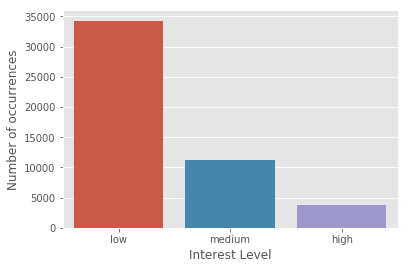

In [5]:
sns.countplot(train_data['interest_level'], order=['low', 'medium', 'high']);
plt.xlabel('Interest Level');
plt.ylabel('Number of occurrences');

Most of the listings have a lower interest and kind of make sense that not every listing is sought after.
It also shows our classes are imbalanced.

## Explore Independant Variables

The independant variables that we have got are:
* bathrooms
* bedrooms 
* building_id
* created
* description
* display_address
* features
* latitude
* listing_id
* longitude
* manager_id
* photos
* price
* street_address

Before we explore, it's worth building a mental map from our own experience how could each one of these features could influence the interest level.
* __bedrooms__: a unit having 2-4 bedrooms should have the highest interest, anything more than that will be expensive and will require quite a few people together to come to an agreement
* __bathrooms__: similarly around 1-2 bathrooms in a unit should have the highest interest.
* __building_id__: this is most probably an internal id for Renthop, so it should tell us if a particular unit was sought after or was disliked by people in the past.
* __created__ : people will prefer newer units ?
* __display_address, latitude, longtiude, street_adress__: I am not sure, how this will directly tell us about interest levels. On the other hand, it should tell us whether a place is located in a safe and secure place and close to amenities.
* __features__: basic features such as internet, park, washing machine, dish washer, no extra price, for bills, close to a train station is loved by all.
* __manager_id__: i believe if a manager can sell well a place with a proper description, targeting the right group of people, it will create more interest.
* __photos__: a decent number of photos of all rooms make a place much more convinving amount potential buyers/tennants. I believe a place with no photos with have low interest.
* __price__: as humans we always want the max amount of things for the lowest price.

### Quick overview of the numerical data

In [6]:
train_data[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']].describe()

bathrooms      bedrooms      latitude     longitude         price
count  49352.00000  49352.000000  49352.000000  49352.000000  4.935200e+04
mean       1.21218      1.541640     40.741545    -73.955716  3.830174e+03
std        0.50142      1.115018      0.638535      1.177912  2.206687e+04
min        0.00000      0.000000      0.000000   -118.271000  4.300000e+01
25%        1.00000      1.000000     40.728300    -73.991700  2.500000e+03
50%        1.00000      1.000000     40.751800    -73.977900  3.150000e+03
75%        1.00000      2.000000     40.774300    -73.954800  4.100000e+03
max       10.00000      8.000000     44.883500      0.000000  4.490000e+06

It's interesting to see some listings have some listings have 0 bathrooms and bedrooms.
<br>
The mininum and maximum price of a listing are \$43 and \$4.4M respectively. Also, min latitude and max longitude are 0 degrees. Outliers?

Now, let's look one feature at a time.

### Bathrooms

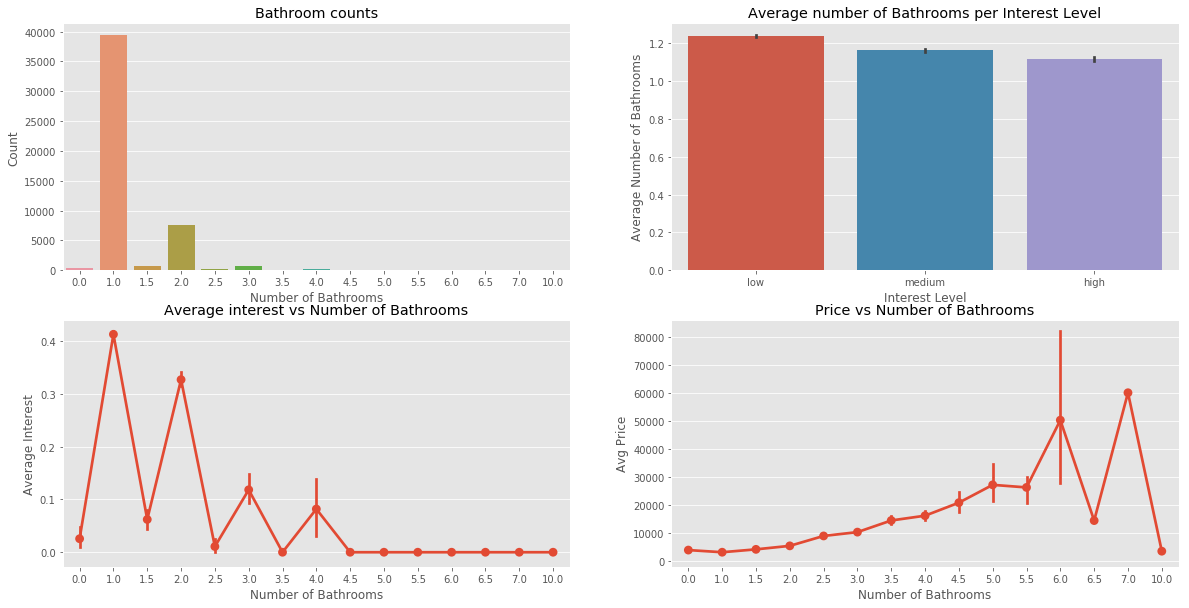

In [7]:
fig = plt.figure(figsize=(20,10))

sns.countplot(train_data['bathrooms'], ax = plt.subplot(221))
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.title("Bathroom counts")

sns.barplot(x='interest_level', y='bathrooms', 
            order=['low', 'medium', 'high'], 
            data=train_data, 
            ax = plt.subplot(222))
plt.xlabel('Interest Level')
plt.ylabel('Average Number of Bathrooms')
plt.title("Average number of Bathrooms per Interest Level")

sns.pointplot(x="bathrooms", y="interest", 
              data=train_data, 
              ax = plt.subplot(223))
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Interest')
plt.title("Average interest vs Number of Bathrooms")

sns.pointplot(x="bathrooms", y="price", 
              data=train_data, 
              ax = plt.subplot(224))
plt.xlabel('Number of Bathrooms')
plt.ylabel('Avg Price')
plt.title("Price vs Number of Bathrooms")

We can see most of the listings have 1 or 2 bathrooms and people are more interested on listings with fewer number _(1 or 2)_ of bathrooms. As expected, as the number of bathrooms increases, price of a unit also increases.

### Bedrooms

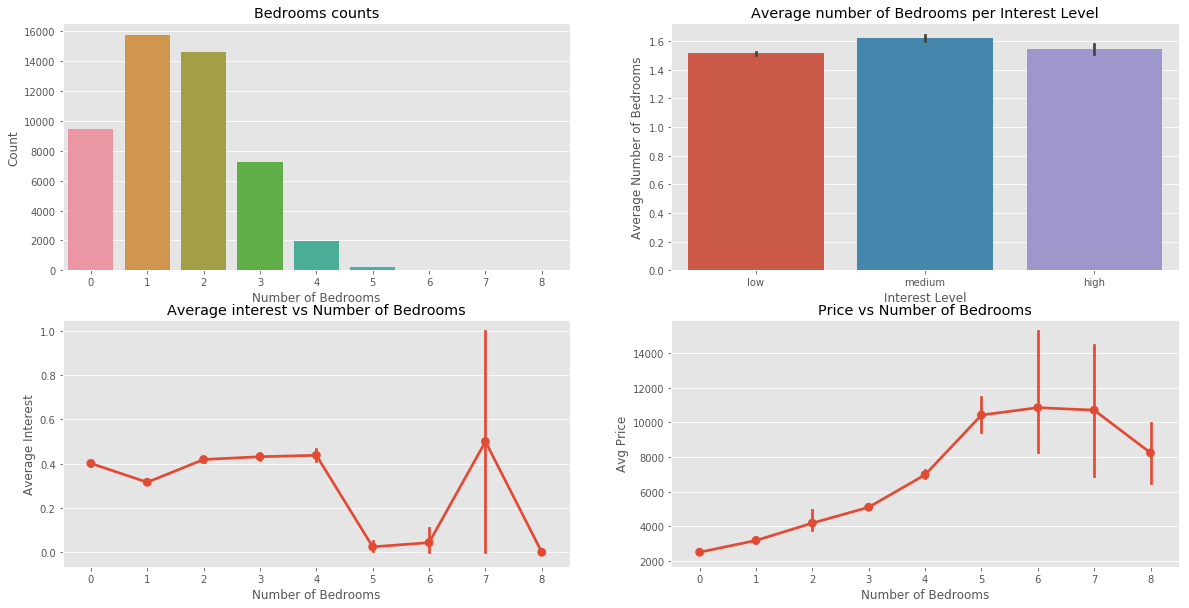

In [8]:
fig = plt.figure(figsize=(20,10))

sns.countplot(train_data['bedrooms'], ax = plt.subplot(221));
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.title("Bedrooms counts")

sns.barplot(x='interest_level', y='bedrooms', 
            data=train_data, 
            order=['low', 'medium', 'high'],
            ax = plt.subplot(222))
plt.xlabel('Interest Level')
plt.ylabel('Average Number of Bedrooms')
plt.title("Average number of Bedrooms per Interest Level")

sns.pointplot(x="bedrooms", y="interest", 
              data=train_data, 
              ax = plt.subplot(223))
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Interest')
plt.title("Average interest vs Number of Bedrooms")

sns.pointplot(x="bedrooms", y="price", 
              data=train_data, 
              ax = plt.subplot(224))
plt.xlabel('Number of Bedrooms')
plt.ylabel('Avg Price')
plt.title("Price vs Number of Bedrooms")

We again see listings with 2-4 bedrooms in general have more average interest.

### Created

In [9]:
train_data.created = pd.to_datetime(train_data.created, format='%Y-%m-%d %H:%M:%S')
                                    
train_data['hour'] = train_data.created.dt.hour
train_data['date'] = train_data.created.dt.date
train_data['day_of_week'] = train_data.created.dt.weekday_name
train_data['day_of_week_n'] = train_data.created.dt.weekday
train_data['month'] = train_data.created.dt.month
train_data['year'] = train_data.created.dt.year

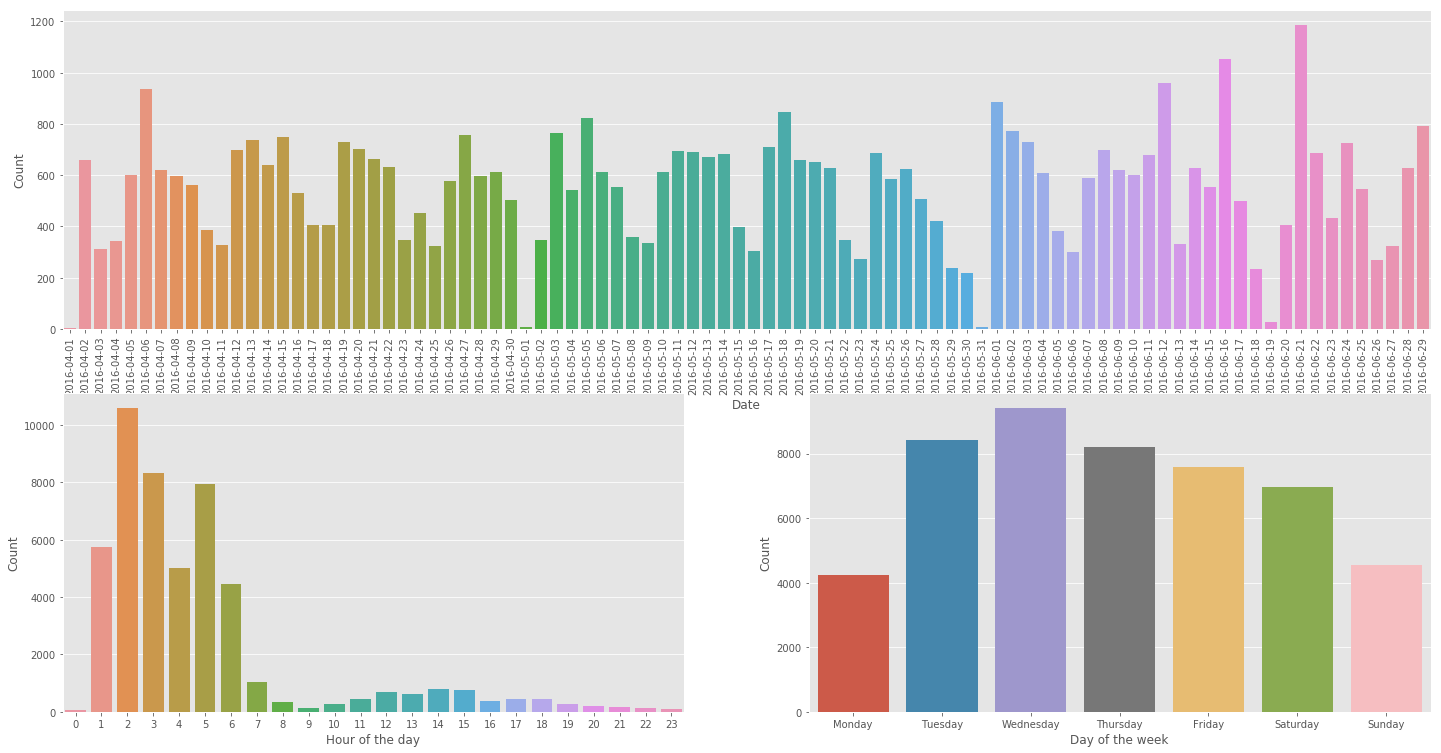

In [10]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(bottom=0.0001, left=0.025, top = 0.975, right=0.975)

sns.countplot(x="date",
              data=train_data.sort_values('date'),
              ax = plt.subplot(211))
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation='vertical')

sns.countplot(x="hour",
              data=train_data,
              ax = plt.subplot(223))
plt.xlabel('Hour of the day')
plt.ylabel('Count')

sns.countplot(x="day_of_week",
              order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
              data=train_data, 
              ax = plt.subplot(224))
plt.xlabel('Day of the week')
plt.ylabel('Count')

All the listings were created from Apr-June 2016.
Additionally, most of them were created in the less busy hours *(early mornings)* from Tuesday-Saturday of the week.

### Price

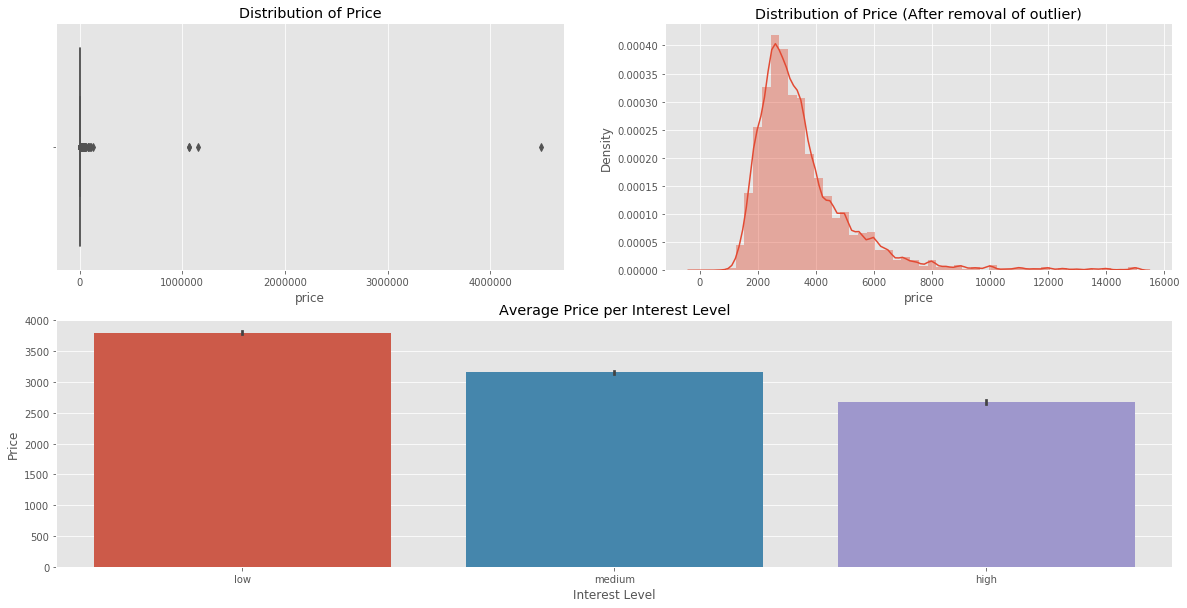

In [11]:
fig = plt.figure(figsize=(20,10))

# Check for Outlier
sns.boxplot(train_data['price'], 
               ax = plt.subplot(221))
plt.title("Distribution of Price")

ulimit = train_data['price'].quantile(0.995)
train_price_nooutlier = train_data.loc[train_data['price'] < ulimit , :]
sns.distplot(train_price_nooutlier['price'], 
               ax = plt.subplot(222))
plt.ylabel("Density")
plt.title("Distribution of Price (After removal of outlier)")

sns.barplot(x="interest_level", y="price", 
            order=['low', 'medium', 'high'],
            data=train_price_nooutlier, 
            ax=plt.subplot(212));
plt.xlabel("Interest Level")
plt.ylabel("Price")
plt.title("Average Price per Interest Level")

As expected, we see the \$4.4M outlier. Hence, we considered only the top 99 percentile.
<br>
Additionally, we can also see there is a higher interest for lower priced listings.

### Photos

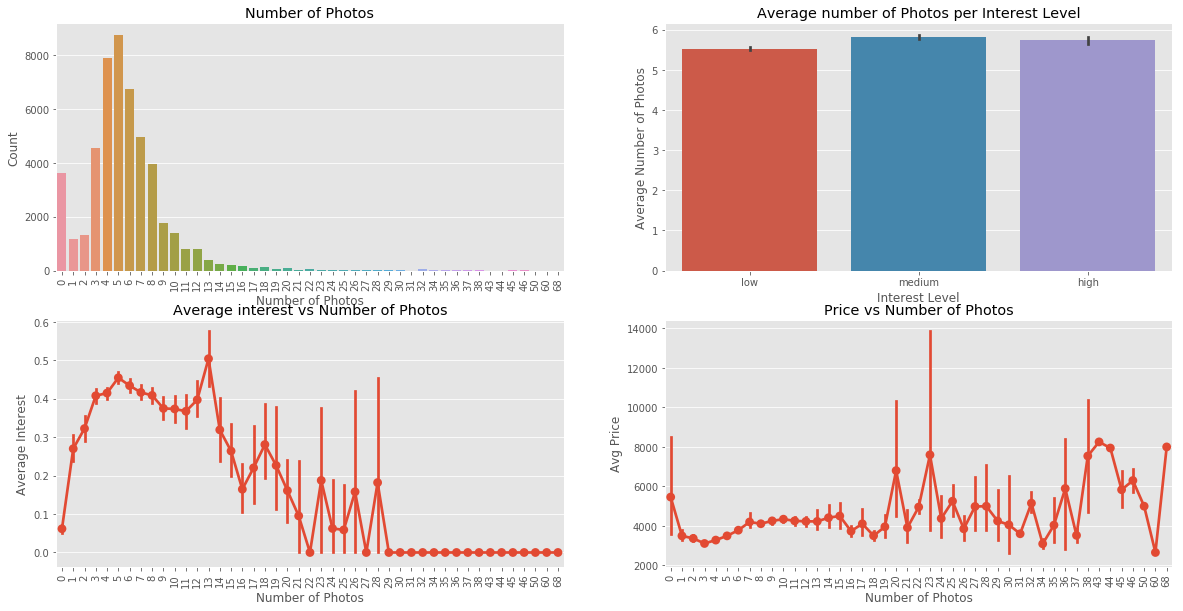

In [12]:
train_data['num_photos'] = train_data['photos'].str.len()

fig = plt.figure(figsize=(20,10))

sns.countplot(train_data['num_photos'], ax = plt.subplot(221));
plt.xlabel('Number of Photos')
plt.ylabel('Count')
plt.title("Number of Photos")
plt.xticks(rotation='vertical')

sns.barplot(x='interest_level', y='num_photos', 
            data=train_data, 
            order=['low', 'medium', 'high'],
            ax = plt.subplot(222))
plt.xlabel('Interest Level')
plt.ylabel('Average Number of Photos')
plt.title("Average number of Photos per Interest Level")

sns.pointplot(x="num_photos", y="interest", 
              data=train_data, 
              ax = plt.subplot(223))
plt.xlabel('Number of Photos')
plt.ylabel('Average Interest')
plt.title("Average interest vs Number of Photos")
plt.xticks(rotation='vertical')

sns.pointplot(x="num_photos", y="price", 
              data=train_data, 
              ax = plt.subplot(224))
plt.xlabel('Number of Photos')
plt.ylabel('Avg Price')
plt.xticks(rotation='vertical')
plt.title("Price vs Number of Photos")

We can see listings that have fewer number of Photos  have lower interest and also too many photos is overwhelming for people.
So a listing having around 3-15 photos seems to create the most interest.

### Display Address

There are 6331 unique addresses.


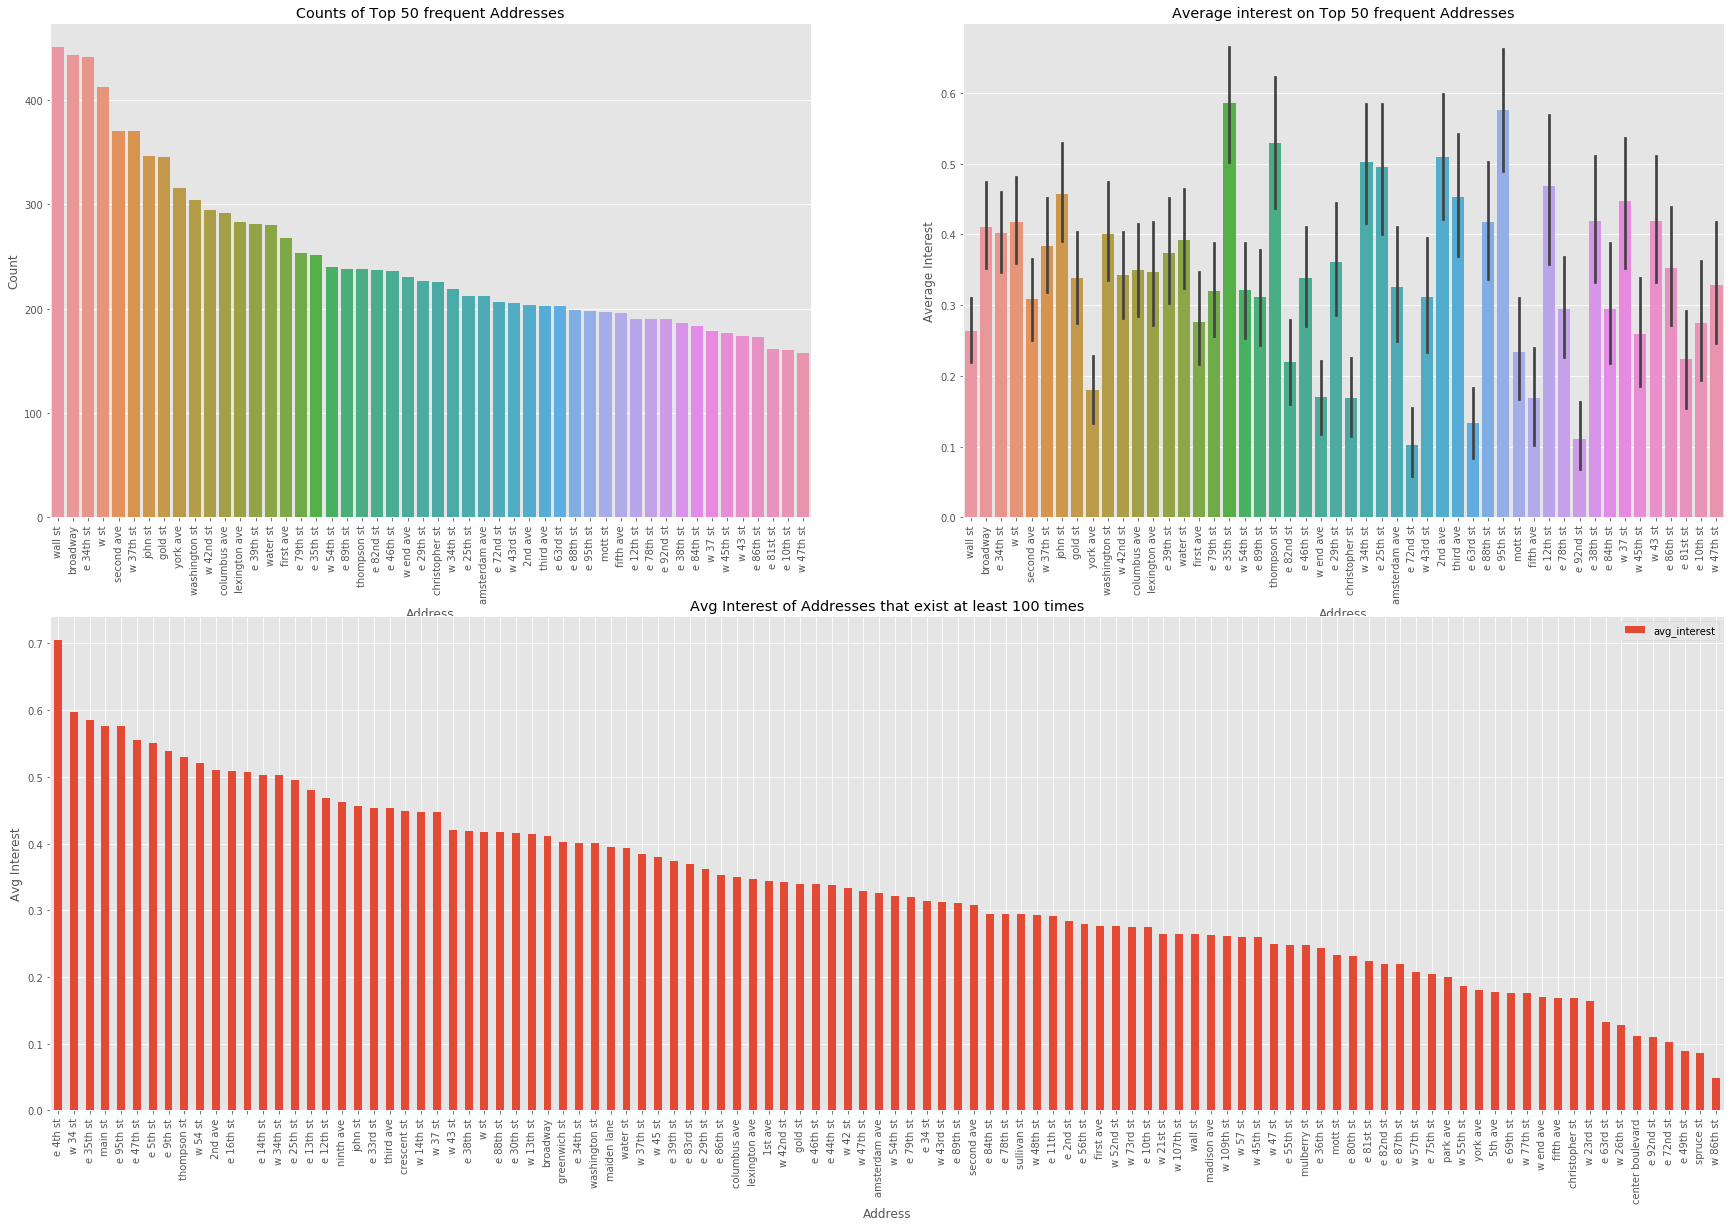

In [50]:
def clean(address):
    return " ".join(address.strip("-,.$*!#&\'\t").replace("'",'').lower()\
              .replace('street', 'st').replace('avenue', 'ave')\
              .replace('east', 'e').replace('west', 'w').split())

train_data["display_address_cl"] = train_data["display_address"].apply(clean)
train_data["street_address_cl"] = train_data["street_address"].apply(clean)

print("There are {} unique addresses.".format(train_data["display_address_cl"].nunique()))

dd = defaultdict(list)
for row in train_data.itertuples():
    add = row.display_address_cl
    dd[add].append(row.interest)

df = pd.DataFrame(list(dd.items()), columns=["address", "address_interest"])
df['avg_interest'] = df["address_interest"].apply(np.mean)
df['count'] = df["address_interest"].apply(len)

fig = plt.figure(figsize=(30,20))
n=50
top_addresses = train_data["display_address_cl"].value_counts().nlargest(n).keys()

sns.countplot(train_data.loc[train_data["display_address_cl"].isin(top_addresses), "display_address_cl"], 
              order = top_addresses,
              ax = plt.subplot(221));
plt.xlabel('Address')
plt.ylabel('Count')
plt.title("Counts of Top {n} frequent Addresses".format(n=n))
plt.xticks(rotation='vertical')

sns.barplot(x="display_address_cl", y="interest", 
            data=train_data.loc[train_data["display_address_cl"].isin(top_addresses), :], 
            order = top_addresses,
            ax = plt.subplot(222))
plt.xlabel('Address')
plt.ylabel('Average Interest')
plt.title("Average interest on Top {n} frequent Addresses".format(n=n))
plt.xticks(rotation='vertical')

ax = df.loc[df["count"]>=100, ["address", "avg_interest"]].sort_values("avg_interest", ascending=False).set_index("address")\
    .plot(kind='bar', title="Avg Interest of Addresses that exist at least 100 times", ax=plt.subplot(212))
ax.set_ylabel("Avg Interest")
ax.set_xlabel("Address")

We see quite a few streets in the east are quite popular.

### Location Coordinates

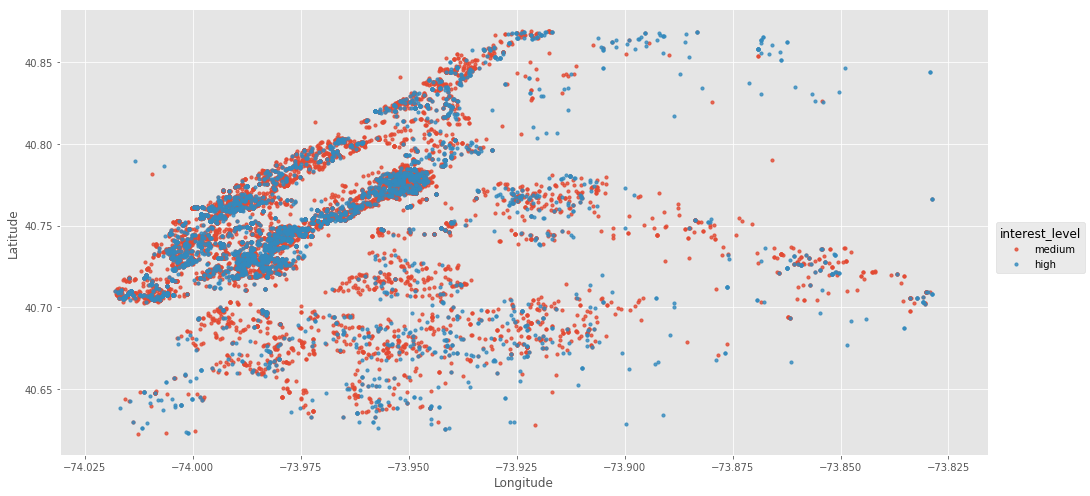

In [65]:
train_ll_nooutlier = train_data.loc[
    (train_data['longitude'] > train_data['longitude'].quantile(0.005)) &
    (train_data['longitude'] < train_data['longitude'].quantile(0.995)) &
    (train_data['latitude']  > train_data['latitude'].quantile(0.005))  &                           
    (train_data['latitude']  < train_data['latitude'].quantile(0.995)), :]

sns.lmplot(x="longitude", y="latitude", 
           fit_reg=False, 
           hue='interest_level',
           hue_order=["medium", "high"],
           scatter = True,
           size=7,
           aspect=2,
           scatter_kws={"s": 10},
           data=train_ll_nooutlier.loc[train_ll_nooutlier["interest_level"].isin(["medium", "high"]), :])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

We can see there are a lot of listings between -73.9 and -74 degrees longitude and 40.70 and 40.80 degrees latitude.

In [56]:
location_list_high = train_ll_nooutlier.loc[train_ll_nooutlier["interest_level"]=='high', 
                                       ["latitude", "longitude", "display_address_cl"]].values.tolist()

nycmap_high = folium.Map(location=[40.74, -73.95], zoom_start=12)
marker_cluster_high = folium.MarkerCluster().add_to(nycmap_high)

for latti, longi, address in location_list_high:
    folium.Marker([latti, longi], popup=address).add_to(marker_cluster_high)

nycmap_high

We see 4 big clusters where demand is _high_.


### Number of features

Total unique features: 1267


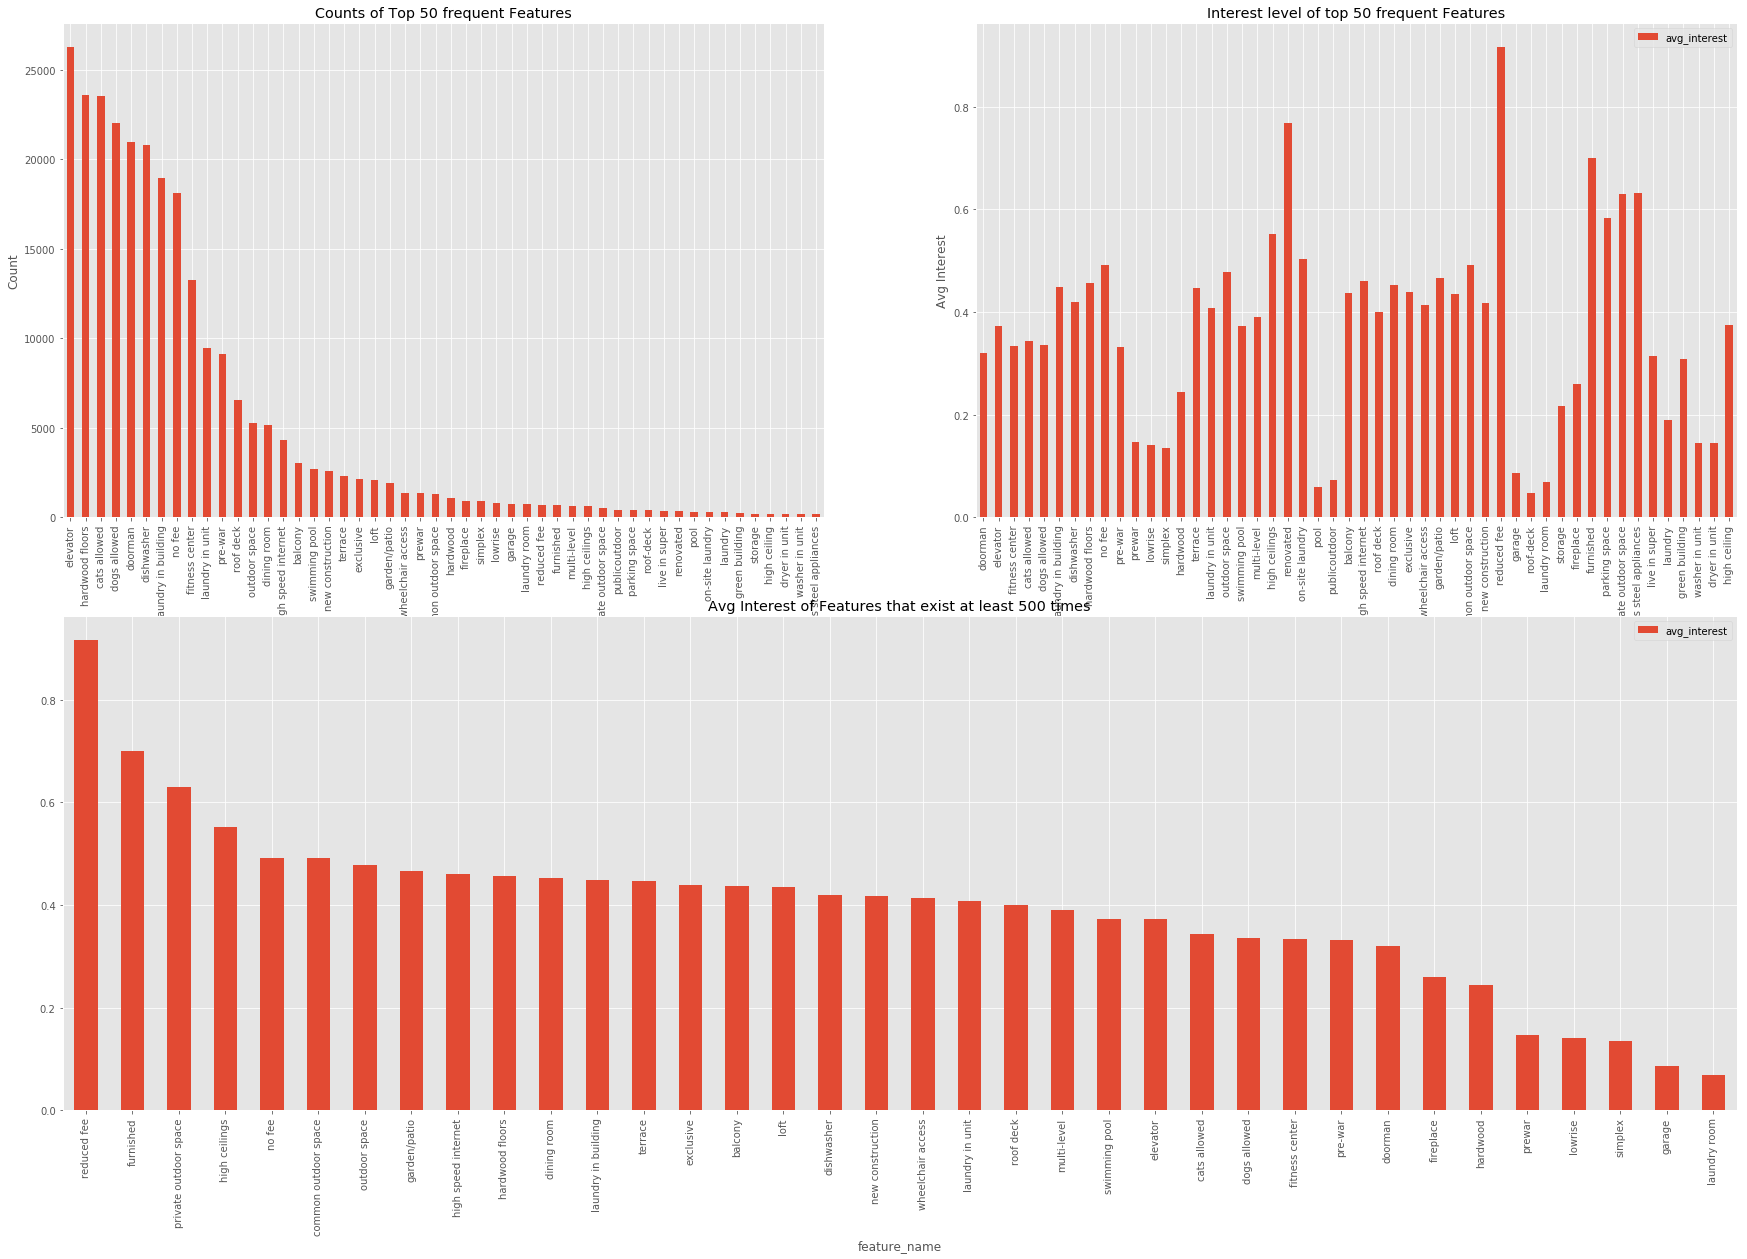

In [15]:
train_data["num_features"] = train_data["features"].apply(len)
train_data["features_cl"] = train_data["features"].apply(lambda fl: list(map(lambda f:f.strip("-,.$*!#&\'\t").replace("'",'').lower(), fl)))
feature_df = pd.Series(list(it.chain.from_iterable(train_data["features_cl"].values.tolist())))
n=50
top_features = feature_df.value_counts().nlargest(n)
print("Total unique features: {}".format(feature_df.nunique()))

dd = defaultdict(list)
for row in train_data.itertuples():
    fl = row.features_cl
    for f in fl:
        dd[f].append(row.interest)

df = pd.DataFrame(list(dd.items()), columns=["feature_name", "feature_interest"])
df['avg_interest'] = df["feature_interest"].apply(np.mean)
df['count'] = df["feature_interest"].apply(len)

fig = plt.figure(figsize=(30,20))
ax = top_features.plot(kind='bar', title="Counts of Top {n} frequent Features".format(n=n), ax=plt.subplot(221))
ax.set_ylabel("Count")

ax = df.loc[df["feature_name"].isin(top_features.keys()), ["feature_name", "avg_interest"]].set_index("feature_name")\
    .plot(kind='bar', title="Interest level of top {n} frequent Features".format(n=n), ax=plt.subplot(222))
ax.set_ylabel("Avg Interest")

df.loc[df["count"]>=500,["feature_name", "avg_interest"]].sort_values("avg_interest", ascending=False).set_index("feature_name")\
    .plot(kind='bar', title="Avg Interest of Features that exist at least 500 times", ax=plt.subplot(212))
ax.set_ylabel("Avg Interest")
ax.set_xlabel("Feature");

We can see that if a listing has reduced_fee, furnished, has outdoor space and internet, it has higher interest.

### Manger Id

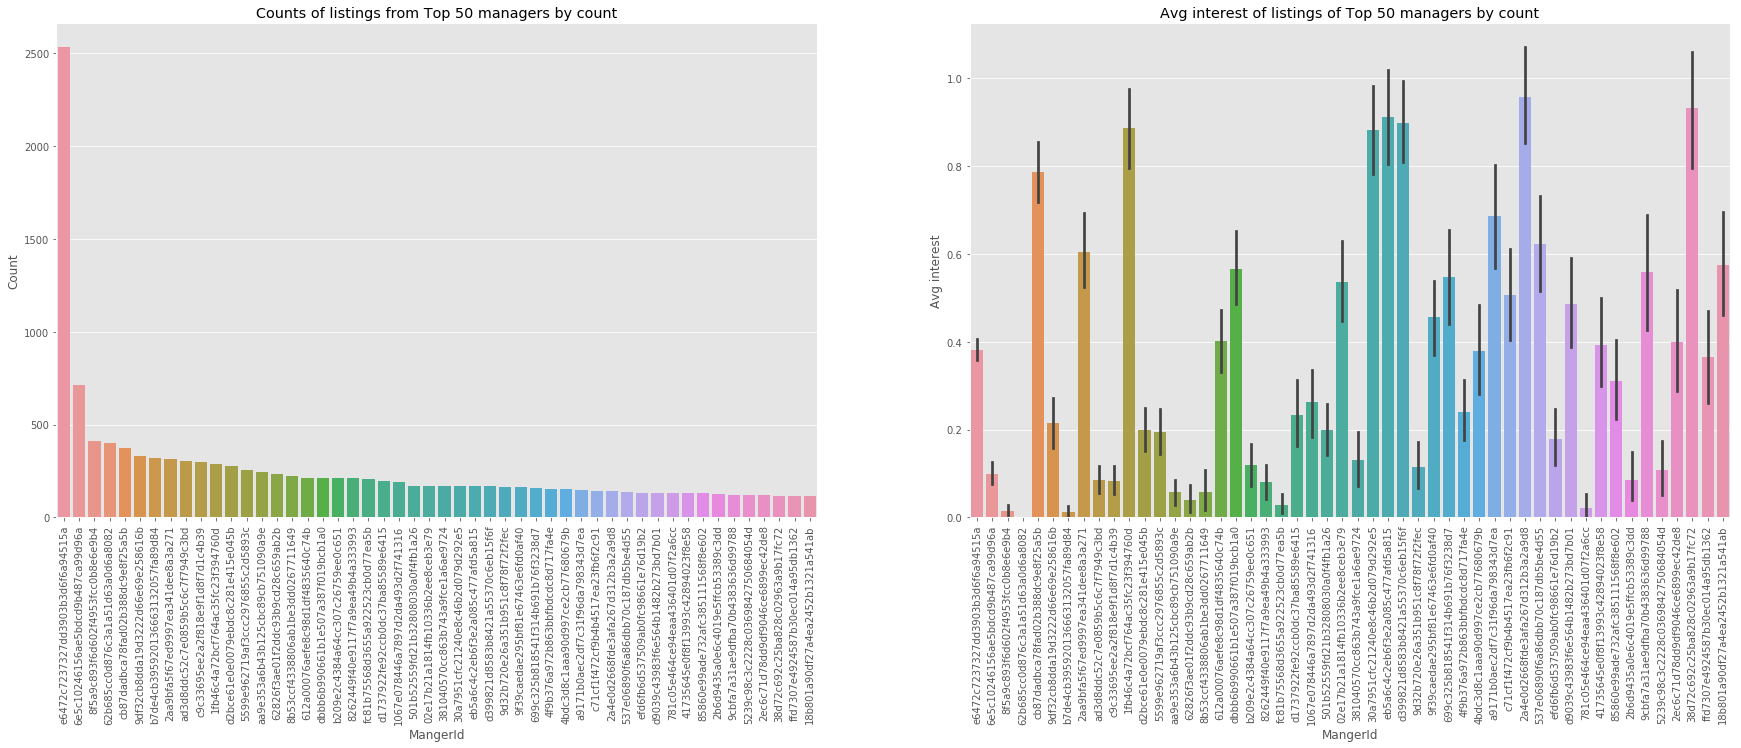

In [16]:
top50_managers = train_data['manager_id'].value_counts(ascending=False).keys()[:50];

fig = plt.figure(figsize=(30,20))
sns.countplot(
    x="manager_id",
    data=train_data.loc[train_data["manager_id"].isin(top50_managers), ["manager_id", "interest_level"]], 
    order = top50_managers,
    ax = plt.subplot(221))
plt.xlabel('MangerId')
plt.ylabel('Count')
plt.title("Counts of listings from Top {n} managers by count".format(n=n))
plt.xticks(rotation='vertical')

sns.barplot(x = 'manager_id', 
            y = 'interest',
            data=train_data.loc[train_data["manager_id"].isin(top50_managers), ["manager_id", "interest"]], 
            order = top50_managers,
            ax = plt.subplot(222))
ax.set_ylabel("Count")
plt.xlabel('MangerId')
plt.ylabel('Avg interest')
plt.title("Avg interest of listings of Top {n} managers by count".format(n=n))
plt.xticks(rotation='vertical');

As we can clearly see different managers have different skill levels, even when they have similar number of entries. Could it because some managers are lucky to get good listings or those managers really do their job well?

### Building Id
https://www.kaggle.com/den3b81/some-insights-on-building-id

Number of entries: 49352, Number of unique buildings: 7585


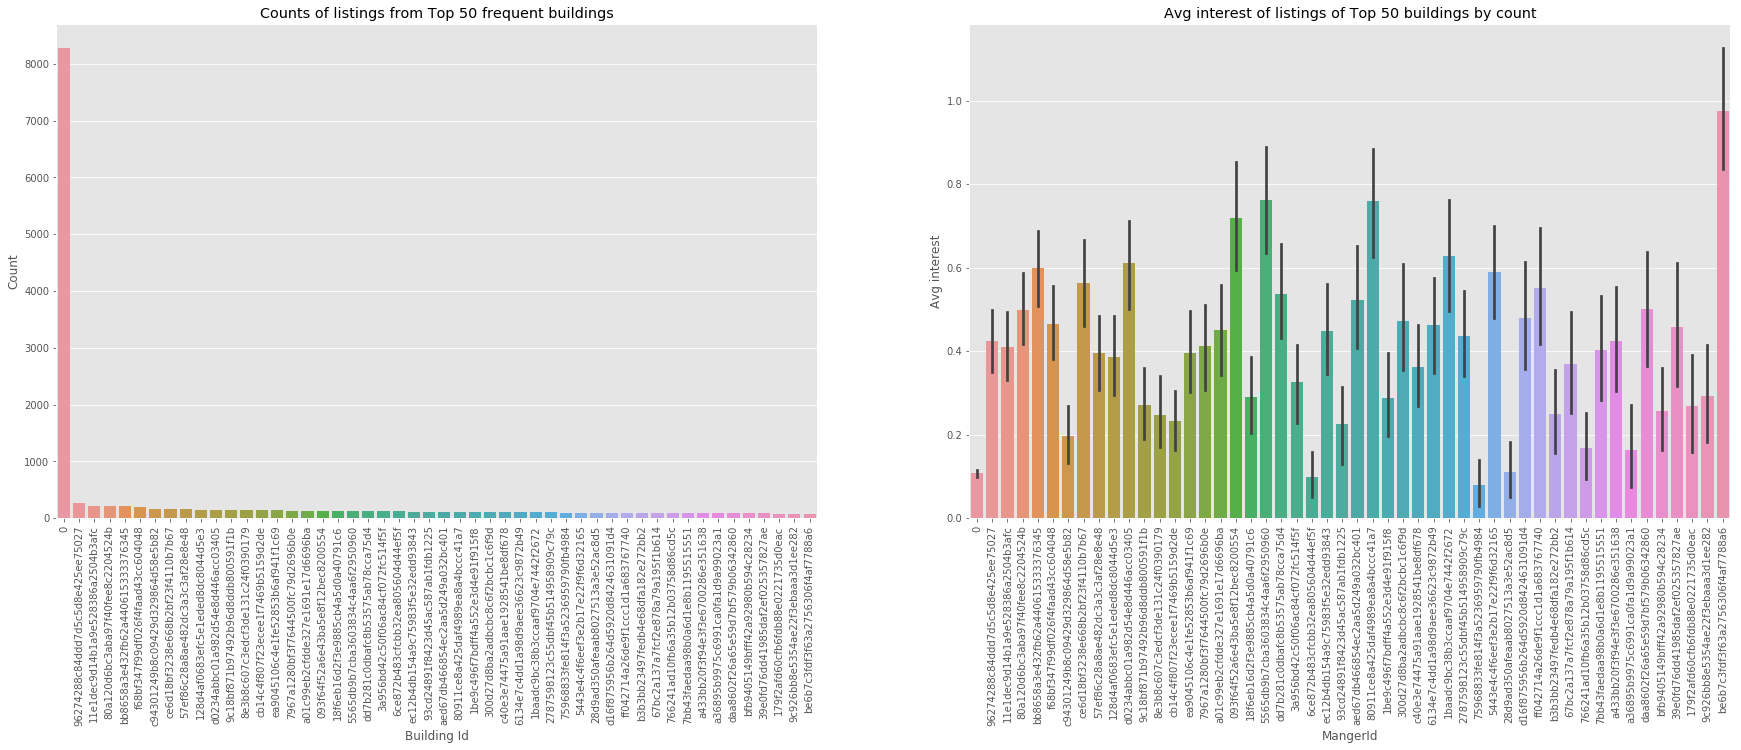

In [45]:
print("Number of entries: {}, Number of unique buildings: {}".format(len(train_data.index), train_data['building_id'].nunique()))
top50_buildings = train_data['building_id'].value_counts(ascending=False).keys()[:50];

fig = plt.figure(figsize=(30,20))
sns.countplot(
    x="building_id",
    data=train_data.loc[train_data["building_id"].isin(top50_buildings), ["building_id", "interest_level"]], 
    order = top50_buildings,
    ax = plt.subplot(221))
plt.xlabel('Building Id')
plt.ylabel('Count')
plt.title("Counts of listings from Top {n} frequent buildings".format(n=n))
plt.xticks(rotation='vertical');

sns.barplot(x = 'building_id', 
            y = 'interest',
            data=train_data.loc[train_data["building_id"].isin(top50_buildings), ["building_id", "interest"]], 
            order = top50_buildings,
            ax = plt.subplot(222))
ax.set_ylabel("Count")
plt.xlabel('MangerId')
plt.ylabel('Avg interest')
plt.title("Avg interest of listings of Top {n} buildings by count".format(n=n))
plt.xticks(rotation='vertical');

In [57]:
location_list_0 = train_data.loc[train_data["building_id"]=='0', 
                                       ["latitude", "longitude", "display_address_cl"]].values.tolist()

nycmap_0 = folium.Map(location=[40.74, -73.95], zoom_start=12)
marker_cluster_0 = folium.MarkerCluster().add_to(nycmap_0)

for latti, longi, address in location_list_0[:3000]:
    folium.Marker([latti, longi], popup=address).add_to(marker_cluster_0)

nycmap_0

It seems there are multiple entries for each building. Interestingly, many buildings are grouped as 0 and its quite a bunch of different buildings and most of them have low interest.

### Description

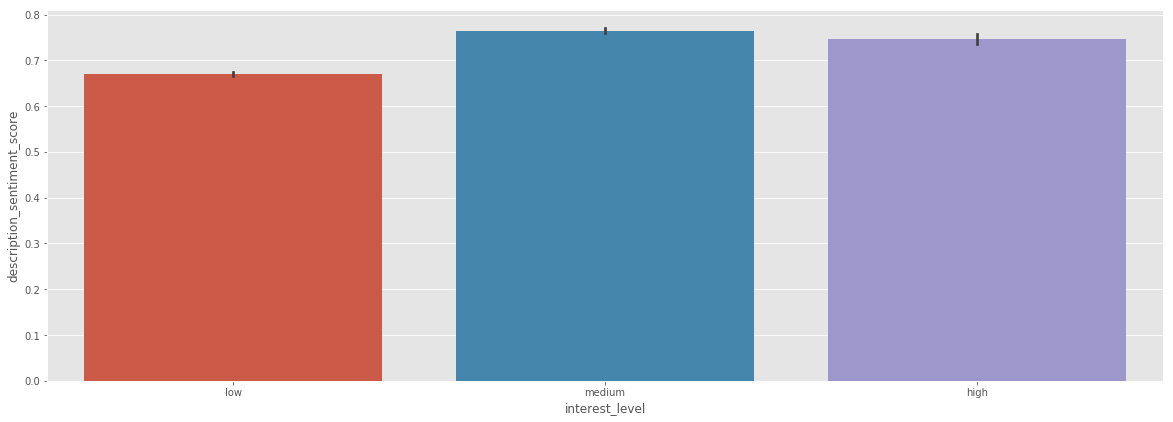

In [89]:
sid = SentimentIntensityAnalyzer()
train_data["description_sentiment_score"] = train_data["description"].apply(lambda desc: sid.polarity_scores(desc).get('compound'))

fig = plt.figure(figsize=(20,15))
sns.barplot(x="interest_level",
            y="description_sentiment_score",
            order = ["low", "medium", "high"],
            data=train_data, 
            ax=plt.subplot(211));

It's interesting to see that sentiment of the description matters when it comes to whether a listing will have higher or lower level of interest. We can clearly see that a positively written description will have a higher level of interest.

## Interaction between 2 variables

# Conclusion 
### Recommendations to RentHop

If a listing has:
1-2 bathrooms, 2-4 bedrooms, located in the East, priced between \$2.7k-\$3.2k, has around 5 photos, has lower fee, is furnished, has outdoor space and internet will probably have high interest.

# Modelling

## Check for NULL

In [19]:
train_data.isnull().sum()

bathrooms             0
bedrooms              0
building_id           0
created               0
description           0
display_address       0
features              0
interest_level        0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        0
interest              0
hour                  0
date                  0
day_of_week           0
day_of_week_n         0
month                 0
year                  0
num_photos            0
display_address_cl    0
street_address_cl     0
num_features          0
features_cl           0
dtype: int64

It seems there are not any rows with NULL values.

## Drop Duplicates & Remove outliers

In [20]:
train_data_nod = train_data.drop_duplicates(["building_id"])
train_data_nod.append(train_data.loc[train_data["building_id"]==0, :], ignore_index=True)

train_nod_nooutlier = train_data_nod.loc[
    (train_data_nod['longitude'] > train_data_nod['longitude'].quantile(0.005))&
    (train_data_nod['longitude'] < train_data_nod['longitude'].quantile(0.995))&
    (train_data_nod['latitude']  > train_data_nod['latitude'].quantile(0.005))&                        
    (train_data_nod['latitude']  < train_data_nod['latitude'].quantile(0.995))&
    (train_data_nod['price']     < train_data_nod['price'].quantile(0.995)), :]

## Create Features

In [21]:
train_nod_nooutlier["descr_length"] = train_nod_nooutlier["description"].apply(lambda desc: len(desc.strip("-,.$*!#&\'\t").replace("'",'').split()))
train_nod_nooutlier["total_rooms"] = train_nod_nooutlier["bedrooms"] + train_nod_nooutlier["bathrooms"]
train_nod_nooutlier["room_diff"] = train_nod_nooutlier["bedrooms"] - train_nod_nooutlier["bathrooms"]
train_nod_nooutlier["bed_per_bath"] = train_nod_nooutlier['bedrooms'] / train_nod_nooutlier['bathrooms']
train_nod_nooutlier["bed_ratio"] = train_nod_nooutlier["bedrooms"] / train_nod_nooutlier["total_rooms"]

median_price = train_nod_nooutlier.price.median()
train_nod_nooutlier["price_diff"] = train_nod_nooutlier["price"].apply(lambda p: p - median_price )
train_nod_nooutlier["price_ratio"] = train_nod_nooutlier["price"].apply(lambda p: p / median_price )
train_nod_nooutlier["price_per_room"] = train_nod_nooutlier["price"]/train_nod_nooutlier["total_rooms"]

train_nod_nooutlier.loc[(train_nod_nooutlier["total_rooms"] == 0), ["price_per_room", "bed_ratio"]] = -1
train_nod_nooutlier.loc[(train_nod_nooutlier["bathrooms"] == 0), "bed_per_bath"] = -1

In [22]:
train_nod_nooutlier.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address', 'interest', 'hour', 'date', 'day_of_week',
       'day_of_week_n', 'month', 'year', 'num_photos', 'display_address_cl',
       'street_address_cl', 'num_features', 'features_cl', 'descr_length',
       'total_rooms', 'room_diff', 'bed_per_bath', 'bed_ratio', 'price_diff',
       'price_ratio', 'price_per_room'],
      dtype='object')

In [23]:
def create_binary_features(df):
    fmap = {
        "pets_allowed": ["dogs", "dog", "cats", "cat"],
        "no_or_low_fee": ["no fee", "nofee", "no  fee", "nofee", "no_fee", "lowfee", "reduced_fee", "low_fee", "reduced fee", "low fee"],
        "furnished": ["furnished"],
        "outdoor_space": ["outdoor space", "garden", "terrace", "balcony", "roof deck"],
        "prewar": ["prewar", "pre_war", "pre war", "pre-war"],
        "facilities": ["dishwasher", "fireplace", "laundry", "swimming", "health", "gym", "fitness", "training", "internet", "elevator"],
        "parking": ["parking", "garage"],
        "transport": ["train", "subway", "transport"],
        "utilities": ["utilities", "heat water", "water included"],
        "new_construction": ["new_construction", "new"],
        "dining_room": ["dining"]
    }
    df_copy = df.copy()
    features_str_df = df_copy["features_cl"].apply(lambda features: " ".join(features))
    for key in fmap:
        df_copy[key] = features_str_df.apply(lambda features: int(any([v in features for v in fmap[key]])))
    return df_copy

train_nod_nooutlier = create_binary_features(train_nod_nooutlier)

In [24]:
features = ["bathrooms", "bedrooms", "latitude", "longitude", "price", "num_photos", "num_features", "hour", "day_of_week_n", "month", 
            "descr_length", "total_rooms", "room_diff", "price_diff", "price_ratio", "price_per_room", "bed_per_bath", "bed_ratio", 
            "building_id", "street_address_cl", "pets_allowed", "no_or_low_fee", "furnished", "outdoor_space", "prewar",
            "facilities", "parking", "transport", "utilities", "new_construction", "dining_room"]
train_nod_nooutlier["building_id"] = train_nod_nooutlier["building_id"].astype('category')
train_nod_nooutlier["street_address_cl"] = train_nod_nooutlier["street_address_cl"].astype('category')

X = train_nod_nooutlier[features]
y = train_nod_nooutlier["interest"]
X.head()

bathrooms  bedrooms  latitude  longitude  price  num_photos  \
10            1.5         3   40.7145   -73.9425   3000           5   
10000         1.0         2   40.7947   -73.9667   5465          11   
100004        1.0         1   40.7388   -74.0018   2850           8   
100007        1.0         1   40.7539   -73.9677   3275           3   
100013        1.0         4   40.8241   -73.9493   3350           3   

        num_features  hour  day_of_week_n  month     ...      no_or_low_fee  \
10                 0     7              4      6     ...                  0   
10000              5    12              6      6     ...                  0   
100004             4     3              6      4     ...                  0   
100007             2     2              0      4     ...                  1   
100013             1     1              3      4     ...                  0   

        furnished  outdoor_space  prewar  facilities  parking  transport  \
10              0              0       0           0        0          0   
10000           0              0       0           1        0          0   
100004          0              0       0           1        0          0   
100007          0              0       0           0        0          0   
100013          0              0       1           0        0          0   

        utilities new_construction dining_room  
10              0                0           0  
10000           0                0           0  
100004          0                0           0  
100007          0                0           0  
100013          0                0           0  

[5 rows x 31 columns]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=10)

## Training
### Baseline Model
A model that predicts with same probablity for all the classes. So that we know any model has to be better than this.

Baseline Log Loss: 1.0986122886681096


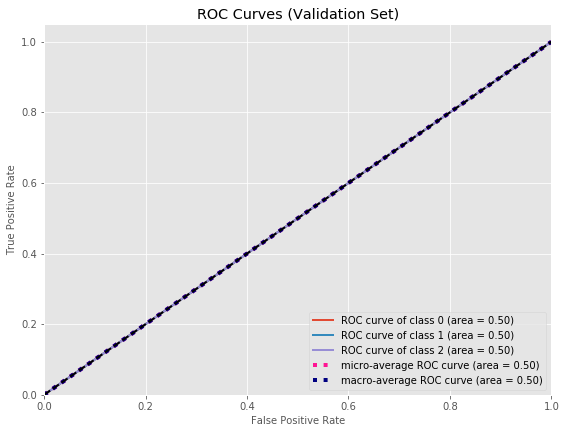

In [26]:
y_val_bl = np.ones([len(y_val), 3])/3
print("Baseline Log Loss: {}".format(log_loss(y_val, y_val_bl)))

fig = plt.figure(figsize=(20,15))
ax = skplt.plot_roc_curve(y_val, y_val_bl, ax=plt.subplot(221))
ax.set_title("ROC Curves (Validation Set)")

### Logistic Regression

Train LR Log Loss: 0.8540852376848376
Val LR Log Loss: 0.8639464243199831


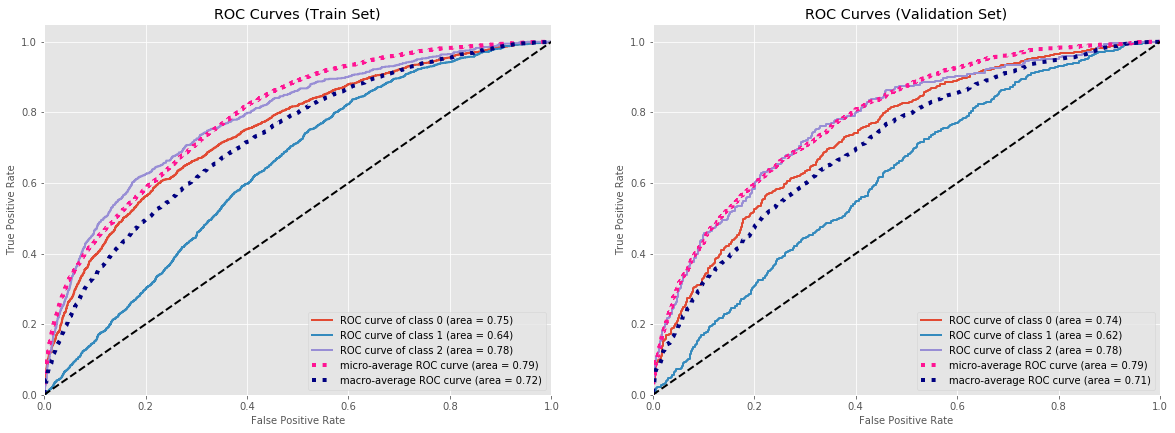

In [27]:
drop_cols = ["building_id", "street_address_cl"]

Cs = np.logspace(-3, 1, 10)
clf_lr = LogisticRegressionCV(Cs=Cs, scoring='neg_log_loss').fit(X_train.drop(drop_cols, axis=1), y_train)

y_train_lr = clf_lr.predict_proba(X_train.drop(drop_cols, axis=1))
y_val_lr = clf_lr.predict_proba(X_val.drop(drop_cols, axis=1))

print("Train LR Log Loss: {}".format(log_loss(y_train, y_train_lr)))
print("Val LR Log Loss: {}".format(log_loss(y_val, y_val_lr)))

fig = plt.figure(figsize=(20,15))
ax = skplt.plot_roc_curve(y_train, y_train_lr, ax=plt.subplot(221))
ax.set_title("ROC Curves (Train Set)")
ax = skplt.plot_roc_curve(y_val, y_val_lr, ax=plt.subplot(222))
ax.set_title("ROC Curves (Validation Set)")

### LightGBM

Train LR Log Loss: 0.71197755733289
Val LR Log Loss: 0.7919271406490931


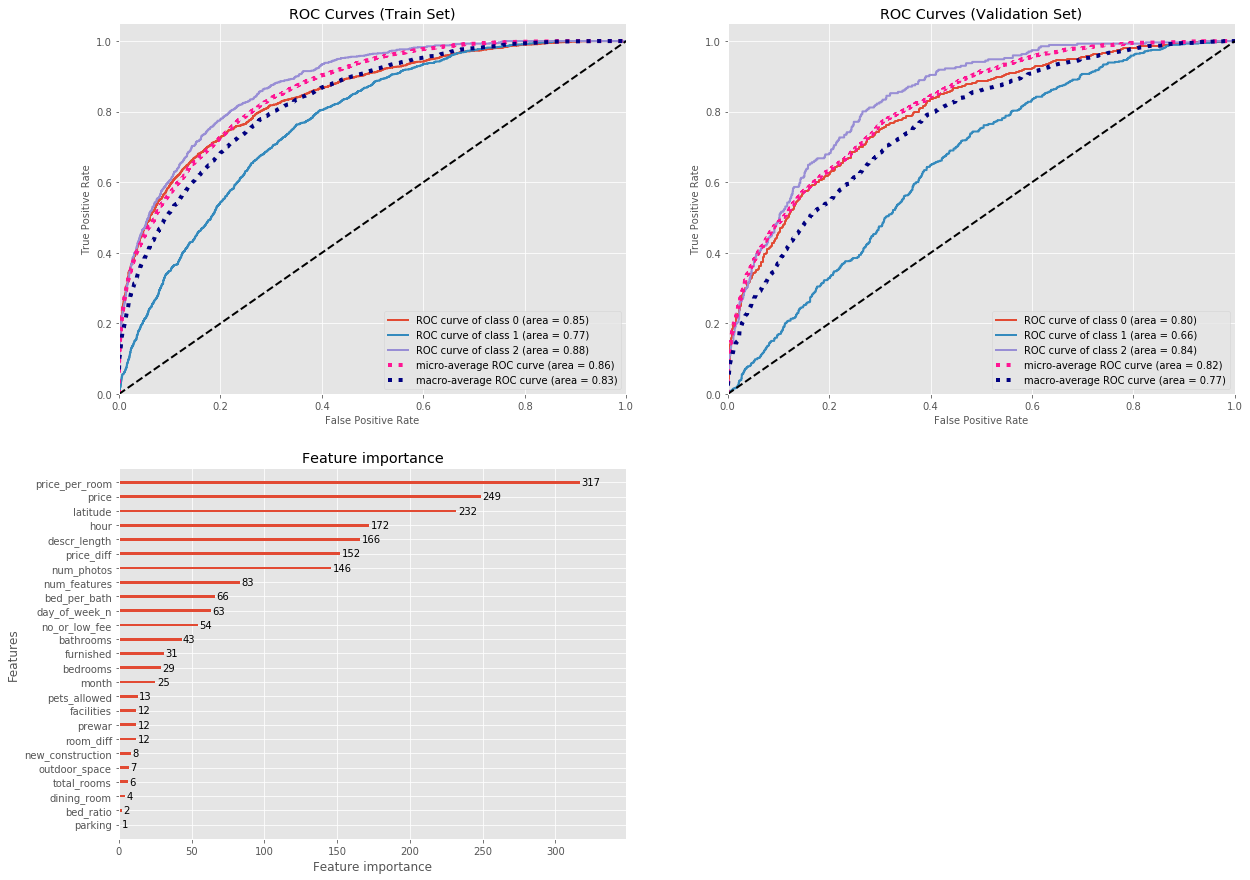

In [28]:
clf_lgb =  LGBMClassifier(n_estimators=100, 
                          learning_rate=0.1,
                          boosting_type='gbdt',
                          objective='multi:softprob',
                          max_depth = 3,
                          colsample_bytree=1,
                          num_leaves = 20,
                          
                         )
clf_lgb.fit(X_train, y_train)


y_train_lgb = clf_lgb.predict_proba(X_train)
y_val_lgb = clf_lgb.predict_proba(X_val)

print("Train LR Log Loss: {}".format(log_loss(y_train, y_train_lgb)))
print("Val LR Log Loss: {}".format(log_loss(y_val, y_val_lgb)))

fig = plt.figure(figsize=(20,15))
ax = skplt.plot_roc_curve(y_train, y_train_lgb, ax=plt.subplot(221))
ax.set_title("ROC Curves (Train Set)")
ax = skplt.plot_roc_curve(y_val, y_val_lgb, ax=plt.subplot(222))
ax.set_title("ROC Curves (Validation Set)")
lgb.plot_importance(clf_lgb, ax=plt.subplot(223))

### Xgboost

Train LR Log Loss: 0.7045938640749224
Val LR Log Loss: 0.781541473654717


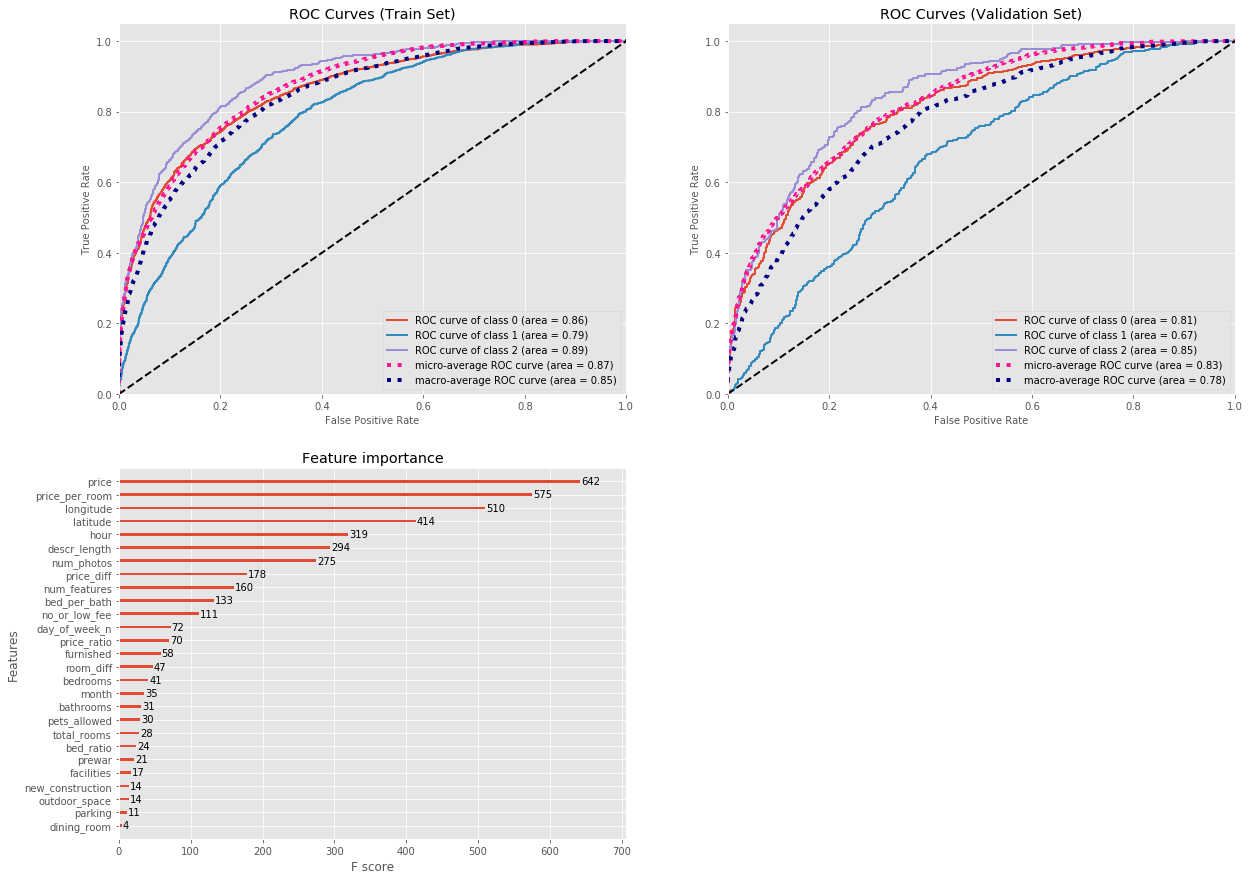

In [29]:
clf_xgb =  xgb.XGBClassifier(objective='multi:softprob', 
                             max_depth=4, 
                             learning_rate=0.05, 
                             subsample=0.85, 
                             colsample_bylevel=0.85, 
                             colsample_bytree=0.85, 
                             gamma=0.1, 
                             n_estimators=100, 
                             nthread=4
                         )
clf_xgb.fit(X_train.drop(drop_cols, axis=1), y_train)

y_train_xgb = clf_xgb.predict_proba(X_train.drop(drop_cols, axis=1))
y_val_xgb = clf_xgb.predict_proba(X_val.drop(drop_cols, axis=1))

print("Train LR Log Loss: {}".format(log_loss(y_train, y_train_xgb)))
print("Val LR Log Loss: {}".format(log_loss(y_val, y_val_xgb)))

fig = plt.figure(figsize=(20,15))
ax = skplt.plot_roc_curve(y_train, y_train_xgb, ax=plt.subplot(221))
ax.set_title("ROC Curves (Train Set)")
ax = skplt.plot_roc_curve(y_val, y_val_xgb, ax=plt.subplot(222))
ax.set_title("ROC Curves (Validation Set)")
xgb.plot_importance(clf_xgb, ax=plt.subplot(223))

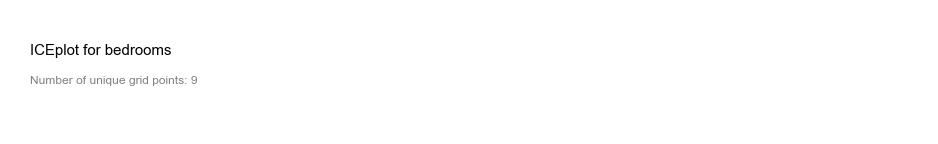

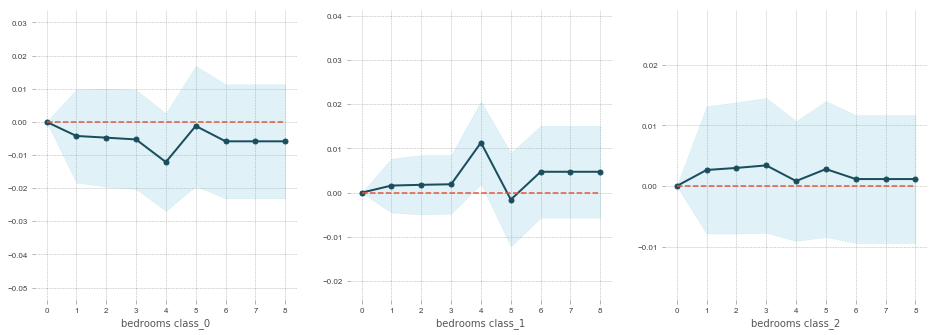

In [30]:
pdp_bedrooms = pdp.pdp_isolate(clf_xgb, X_train.drop(drop_cols, axis=1), 'bedrooms')
pdp.pdp_plot(pdp_bedrooms, 'bedrooms', center=True, x_quantile=True, ncols=3)

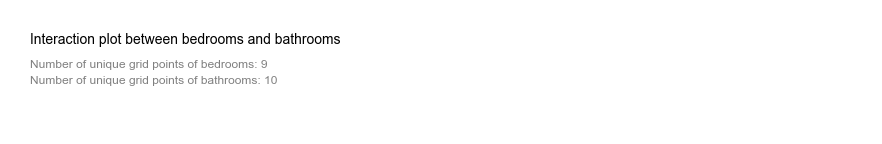

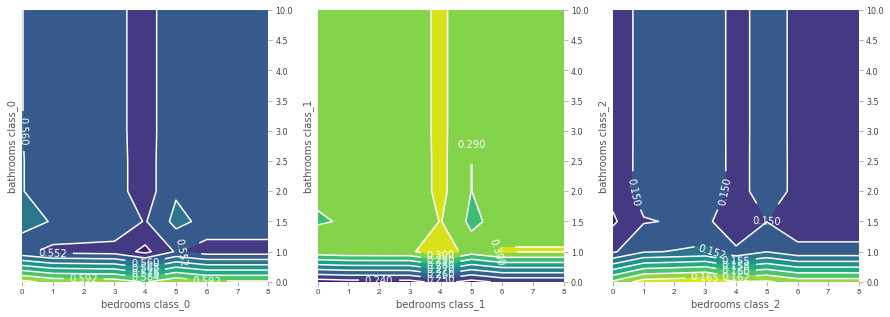

In [31]:
pdp_2 = pdp.pdp_interact(clf_xgb, X_train.drop(drop_cols, axis=1), ['bedrooms', 'bathrooms'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(pdp_2, 
                      ['bedrooms', 'bathrooms'], 
                      center=True, 
                      plot_org_pts=True, 
                      plot_lines=True, 
                      frac_to_plot=0.01, 
                      multi_flag=False, 
                      x_quantile=True, 
                      only_inter=True, 
                      ncols=3)